# Introducing MLlib  

In the previous chapter, we learned how to prepare the data for modeling. In this chapter, we will actually use some of that learning to build a classification model using the MLlib package of PySpark.  

MLlib stands for Machine Learning Library. Even though MLlib is now in a maintenance mode, that is, it is not actively being developed (and will most likely be deprecated later), it is warranted that we cover at least some of the features of the library. In addition, MLlib is currently the only library that supports training models for streaming.

In [1]:
import os
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
import pyspark.sql.types as typ
import findspark
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook

from bokeh.models import ColumnDataSource, FactorRange


In [2]:
findspark.init("C:/Program Files/spark-3.5.4-bin-hadoop3")

In [3]:
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jre1.8.0_431" 
os.environ["SPARK_HOME"] = "C:/Program Files/spark-3.5.4-bin-hadoop3" 
os.environ['HADOOP_HOME '] = 'C:/Program Files/hadoop-3.4.0'

In [4]:
# Create a SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MyApp") \
    .master("local[4]") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

sc = spark.sparkContext  # Accès au SparkContext à partir de SparkSession


In [5]:



# Accéder au SparkContext à partir de SparkSession
sc = spark.sparkContext

In this chapter, you will learn how to do the following:   
• Prepare the data for modeling with MLlib  
• Perform statistical testing  
• Predict survival chances of infants using logistic regression  
• Select the most predictable features and train a random forest model  

## Overview of the package

At the high level, MLlib exposes three core machine learning functionalities:  
• **Data preparation:** Feature extraction, transformation, selection, hashing of
categorical features, and some natural language processing methods  
• **Machine learning algorithms:** Some popular and advanced regression,
classification, and clustering algorithms are implemented  
• **Utilities:** Statistical methods such as descriptive statistics, chi-square testing,
linear algebra (sparse and dense matrices and vectors), and model evaluation
methods

As you can see, the palette of available functionalities allows you to perform almost
all of the fundamental data science tasks.

In this chapter, we will build two classification models: a linear regression and
a random forest. We will use a portion of the US 2014 and 2015 birth data we
downloaded from http://www.cdc.gov/nchs/data_access/vitalstatsonline.
htm; from the total of 300 variables we selected 85 features that we will use to build
our models. Also, out of the total of almost 7.99 million records, we selected a
balanced sample of 45,429 records: 22,080 records where infants were reported dead
and 23,349 records with infants alive.

## Loading and transforming the data  
Even though MLlib is designed with RDDs and DStreams in focus, for ease of
transforming the data we will read the data and convert it to a DataFrame.

* we first specify the schema of our dataset.

In [6]:
import pyspark.sql.types as typ

labels = [
    ('INFANT_ALIVE_AT_REPORT', typ.StringType()),
    ('BIRTH_YEAR', typ.IntegerType()),
    ('BIRTH_MONTH', typ.IntegerType()),
    ('BIRTH_PLACE', typ.StringType()),
    ('MOTHER_AGE_YEARS', typ.IntegerType()),
    ('MOTHER_RACE_6CODE', typ.StringType()),
    ('MOTHER_EDUCATION', typ.StringType()),
    ('FATHER_COMBINED_AGE', typ.IntegerType()),
    ('FATHER_EDUCATION', typ.StringType()),
    ('MONTH_PRECARE_RECODE', typ.StringType()),
    ('CIG_BEFORE', typ.IntegerType()),
    ('CIG_1_TRI', typ.IntegerType()),
    ('CIG_2_TRI', typ.IntegerType()),
    ('CIG_3_TRI', typ.IntegerType()),
    ('MOTHER_HEIGHT_IN', typ.IntegerType()),
    ('MOTHER_BMI_RECODE', typ.IntegerType()),
    ('MOTHER_PRE_WEIGHT', typ.IntegerType()),
    ('MOTHER_DELIVERY_WEIGHT', typ.IntegerType()),
    ('MOTHER_WEIGHT_GAIN', typ.IntegerType()),
    ('DIABETES_PRE', typ.StringType()),
    ('DIABETES_GEST', typ.StringType()),
    ('HYP_TENS_PRE', typ.StringType()),
    ('HYP_TENS_GEST', typ.StringType()),
    ('PREV_BIRTH_PRETERM', typ.StringType()),
    ('NO_RISK', typ.StringType()),
    ('NO_INFECTIONS_REPORTED', typ.StringType()),
    ('LABOR_IND', typ.StringType()),
    ('LABOR_AUGM', typ.StringType()),
    ('STEROIDS', typ.StringType()),
    ('ANTIBIOTICS', typ.StringType()),
    ('ANESTHESIA', typ.StringType()),
    ('DELIV_METHOD_RECODE_COMB', typ.StringType()),
    ('ATTENDANT_BIRTH', typ.StringType()),
    ('APGAR_5', typ.IntegerType()),
    ('APGAR_5_RECODE', typ.StringType()),
    ('APGAR_10', typ.IntegerType()),
    ('APGAR_10_RECODE', typ.StringType()),
    ('INFANT_SEX', typ.StringType()),
    ('OBSTETRIC_GESTATION_WEEKS', typ.IntegerType()),
    ('INFANT_WEIGHT_GRAMS', typ.IntegerType()),
    ('INFANT_ASSIST_VENTI', typ.StringType()),
    ('INFANT_ASSIST_VENTI_6HRS', typ.StringType()),
    ('INFANT_NICU_ADMISSION', typ.StringType()),
    ('INFANT_SURFACANT', typ.StringType()),
    ('INFANT_ANTIBIOTICS', typ.StringType()),
    ('INFANT_SEIZURES', typ.StringType()),
    ('INFANT_NO_ABNORMALITIES', typ.StringType()),
    ('INFANT_ANCEPHALY', typ.StringType()),
    ('INFANT_MENINGOMYELOCELE', typ.StringType()),
    ('INFANT_LIMB_REDUCTION', typ.StringType()),
    ('INFANT_DOWN_SYNDROME', typ.StringType()),
    ('INFANT_SUSPECTED_CHROMOSOMAL_DISORDER', typ.StringType()),
    ('INFANT_NO_CONGENITAL_ANOMALIES_CHECKED', typ.StringType()),
    ('INFANT_BREASTFED', typ.StringType())
]

schema = typ.StructType([
    typ.StructField(e[0], e[1], False) for e in labels
])

Next, we load the data. The .read.csv(...) method can read either uncompressed
or (as in our case) GZipped comma-separated values. The header parameter set
to True indicates that the first row contains the header, and we use the schema to
specify the correct data types:

In [7]:
births = spark.read.csv('datasets/births_train.csv.gz', header=True, schema=schema)

There are plenty of features in our dataset that are strings. These are mostly
categorical variables that we need to somehow convert to a numeric form.

*[You can glimpse over the original file schema specification here:
ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/DVS/natality/UserGuide2015.pdf.]*

* We will first specify our recode dictionary:

In [8]:
recode_dictionary = {
'YNU': {
'Y': 1,
'N': 0,
'U': 0
}
}

Our goal in this chapter is to predict whether the 'INFANT_ALIVE_AT_REPORT' is
either 1 or 0. Thus, we will drop all of the features that relate to the infant and will
try to predict the infant's chances of surviving only based on the features related to
its mother, father, and the place of birth:

In [9]:
selected_features = [
    'INFANT_ALIVE_AT_REPORT', 
    'BIRTH_PLACE', 
    'MOTHER_AGE_YEARS', 
    'FATHER_COMBINED_AGE', 
    'CIG_BEFORE', 
    'CIG_1_TRI', 
    'CIG_2_TRI', 
    'CIG_3_TRI', 
    'MOTHER_HEIGHT_IN', 
    'MOTHER_PRE_WEIGHT', 
    'MOTHER_DELIVERY_WEIGHT', 
    'MOTHER_WEIGHT_GAIN', 
    'DIABETES_PRE', 
    'DIABETES_GEST', 
    'HYP_TENS_PRE', 
    'HYP_TENS_GEST', 
    'PREV_BIRTH_PRETERM'
]

births_trimmed = births.select(selected_features)

* In our dataset, there are plenty of features with Yes/No/Unknown values; we will
only code Yes to 1; everything else will be set to 0.

There is also a small problem with how the number of cigarettes smoked by the
mother was coded: as 0 means the mother smoked no cigarettes before or during the
pregnancy, between 1-97 states the actual number of cigarette smoked, 98 indicates
either 98 or more, whereas 99 identifies the unknown; we will assume the unknown
is 0 and recode accordingly.

So next we will specify our recoding methods:

In [10]:
import pyspark.sql.functions as func

def recode(col, key):
    return recode_dictionary[key][col]

def correct_cig(feat):
    return func.when(func.col(feat) != 99, func.col(feat)).otherwise(0)

rec_integer = func.udf(recode, typ.IntegerType())

The recode method looks up the correct key from the recode_dictionary (given
the key) and returns the corrected value. The correct_cig method checks when the
value of the feature feat is not equal to 99 and (for that situation) returns the value
of the feature; if the value is equal to 99, we get 0 otherwise.  

We cannot use the recode function directly on a DataFrame; it needs to be converted
to a UDF that Spark will understand. The rec_integer is such a function: by passing
our specified recode function and specifying the return value data type, we can use
it then to encode our Yes/No/Unknown features.  

So, let's get to it. First, we'll correct the features related to the number of cigarettes
smoked:

In [11]:
births_transformed = births_trimmed \
    .withColumn('CIG_BEFORE', correct_cig('CIG_BEFORE'))\
    .withColumn('CIG_1_TRI', correct_cig('CIG_1_TRI'))\
    .withColumn('CIG_2_TRI', correct_cig('CIG_2_TRI'))\
    .withColumn('CIG_3_TRI', correct_cig('CIG_3_TRI'))

The .withColumn(...) method takes the name of the column as its first parameter
and the transformation as the second one. In the previous cases, we do not create
new columns, but reuse the same ones instead.  

Now we will focus on correcting the Yes/No/Unknown features. First, we will
figure out which these are with the following snippet:

In [12]:
cols = [(col.name, col.dataType) for col in births_trimmed.schema]

YNU_cols = []

for i, s in enumerate(cols):
    if s[1] == typ.StringType():
        dis = births.select(s[0]).distinct().rdd.map(lambda row: row[0]).collect()
        
        if 'Y' in dis:
            YNU_cols.append(s[0])

First, we created a list of tuples (cols) that hold column names and corresponding
data types. Next, we loop through all of these and calculate distinct values of all
string columns; if a 'Y' is within the returned list, we append the column name to
the YNU_cols list.  

DataFrames can transform the features in bulk while selecting features. To present
the idea, consider the following example:

In [13]:
births.select([
        'INFANT_NICU_ADMISSION', 
        rec_integer(
            'INFANT_NICU_ADMISSION', func.lit('YNU')
        ) \
        .alias('INFANT_NICU_ADMISSION_RECODE')]
    ).take(5)

[Row(INFANT_NICU_ADMISSION='Y', INFANT_NICU_ADMISSION_RECODE=1),
 Row(INFANT_NICU_ADMISSION='Y', INFANT_NICU_ADMISSION_RECODE=1),
 Row(INFANT_NICU_ADMISSION='U', INFANT_NICU_ADMISSION_RECODE=0),
 Row(INFANT_NICU_ADMISSION='N', INFANT_NICU_ADMISSION_RECODE=0),
 Row(INFANT_NICU_ADMISSION='U', INFANT_NICU_ADMISSION_RECODE=0)]

We select the 'INFANT_NICU_ADMISSION' column and we pass the name of the
feature to the rec_integer method. We also alias the newly transformed column as
'INFANT_NICU_ADMISSION_RECODE'. This way we will also confirm that our UDF
works as intended.  

So, to transform all the YNU_cols in one go, we will create a list of such
transformations, as shown here:

In [14]:
exprs_YNU = [
    rec_integer(x, func.lit('YNU')).alias(x)
    if x in YNU_cols
    else x
    for x in births_transformed.columns
]

births_transformed = births_transformed.select(exprs_YNU)

Let's check if we got it correctly:

In [15]:
births_transformed.select(YNU_cols[-5:]).show(5)

+------------+-------------+------------+-------------+------------------+
|DIABETES_PRE|DIABETES_GEST|HYP_TENS_PRE|HYP_TENS_GEST|PREV_BIRTH_PRETERM|
+------------+-------------+------------+-------------+------------------+
|           0|            0|           0|            0|                 0|
|           0|            0|           0|            0|                 0|
|           0|            0|           0|            0|                 0|
|           0|            0|           0|            0|                 1|
|           0|            0|           0|            0|                 0|
+------------+-------------+------------+-------------+------------------+
only showing top 5 rows



Looks like everything worked as we wanted it to work, so let's get to know our
data better.

## Getting to know your data  

In order to build a statistical model in an informed way, an intimate knowledge of
the dataset is necessary. Without knowing the data it is possible to build a successful
model, but it is then a much more arduous task, or it would require more technical
resources to test all the possible combinations of features. Therefore, after spending
the required 80% of the time cleaning the data, we spend the next 15% getting to
know it!  

### Descriptive statistics  

I normally start with descriptive statistics. Even though the DataFrames expose
the .describe() method, since we are working with MLlib, we will use the
.colStats(...) method.

*[A word of warning: the .colStats(...) calculates the descriptive
statistics based on a sample. For real world datasets this should not really
matter but if your dataset has less than 100 observations you might get
some strange results.]*  

The method takes an RDD of data to calculate the descriptive statistics of and return
a MultivariateStatisticalSummary object that contains the following descriptive
statistics:  

• count(): This holds a row count  
• max(): This holds maximum value in the column  
• mean(): This holds the value of the mean for the values in the column  
• min(): This holds the minimum value in the column  
• normL1(): This holds the value of the L1-Norm for the values in the column  
• normL2(): This holds the value of the L2-Norm for the values in the column  
• numNonzeros(): This holds the number of nonzero values in the column  
• variance(): This holds the value of the variance for the values in the column    

The
following is a snippet that calculates the descriptive statistics of the numeric features:

In [16]:
import pyspark.mllib.stat as st
import numpy as np 

numeric_cols = ['MOTHER_AGE_YEARS','FATHER_COMBINED_AGE',
                'CIG_BEFORE','CIG_1_TRI','CIG_2_TRI','CIG_3_TRI',
                'MOTHER_HEIGHT_IN','MOTHER_PRE_WEIGHT',
                'MOTHER_DELIVERY_WEIGHT','MOTHER_WEIGHT_GAIN'
            ]

numeric_rdd = births_transformed.select(numeric_cols).rdd.map(lambda row: [e for e in row])
mllib_stats = st.Statistics.colStats(numeric_rdd)

for col, m, v in zip(numeric_cols, mllib_stats.mean(), mllib_stats.variance()):
    print('{0}: \t{1:.2f} \t {2:.2f}'.format(col, m, np.sqrt(v)))

MOTHER_AGE_YEARS: 	28.30 	 6.08
FATHER_COMBINED_AGE: 	44.55 	 27.55
CIG_BEFORE: 	1.43 	 5.18
CIG_1_TRI: 	0.91 	 3.83
CIG_2_TRI: 	0.70 	 3.31
CIG_3_TRI: 	0.58 	 3.11
MOTHER_HEIGHT_IN: 	65.12 	 6.45
MOTHER_PRE_WEIGHT: 	214.50 	 210.21
MOTHER_DELIVERY_WEIGHT: 	223.63 	 180.01
MOTHER_WEIGHT_GAIN: 	30.74 	 26.23


As you can see, mothers, compared to fathers, are younger: the average age of
mothers was 28 versus over 44 for fathers. A good indication (at least for some of the
infants) was that many mothers quit smoking while being pregnant; it is horrifying,
though, that there still were some that continued smoking.  

For the categorical variables, we will calculate the frequencies of their values:

In [17]:
categorical_cols = [e for e in births_transformed.columns if e not in numeric_cols]

categorical_rdd = births_transformed.select(categorical_cols).rdd.map(lambda row: [e for e in row])

for i, col in enumerate(categorical_cols):
    agg = categorical_rdd.groupBy(lambda row: row[i]).map(lambda row: (row[0], len(row[1])))
    
    print(col, sorted(agg.collect(), key=lambda el: el[1], reverse=True))

INFANT_ALIVE_AT_REPORT [(1, 23349), (0, 22080)]
BIRTH_PLACE [('1', 44558), ('4', 327), ('3', 224), ('2', 136), ('7', 91), ('5', 74), ('6', 11), ('9', 8)]
DIABETES_PRE [(0, 44881), (1, 548)]
DIABETES_GEST [(0, 43451), (1, 1978)]
HYP_TENS_PRE [(0, 44348), (1, 1081)]
HYP_TENS_GEST [(0, 43302), (1, 2127)]
PREV_BIRTH_PRETERM [(0, 43088), (1, 2341)]


Most of the deliveries happened in hospital (BIRTH_PLACE equal to 1). Around 550
deliveries happened at home: some intentionally ('BIRTH_PLACE' equal to 3), and
some not ('BIRTH_PLACE' equal to 4).

### Correlations  

Correlations help to identify collinear numeric features and handle them
appropriately. Let's check the correlations between our features:

In [18]:
corrs = st.Statistics.corr(numeric_rdd)

for i, el in enumerate(corrs > 0.5):
    correlated = [
        (numeric_cols[j], corrs[i][j]) for j, e in enumerate(el) if e == 1.0 and j != i
    ]
    
    if len(correlated) > 0:
        for e in correlated:
            print('{0}-to-{1}: {2:.2f}'.format(numeric_cols[i], e[0], e[1]))

CIG_BEFORE-to-CIG_1_TRI: 0.83
CIG_BEFORE-to-CIG_2_TRI: 0.72
CIG_BEFORE-to-CIG_3_TRI: 0.62
CIG_1_TRI-to-CIG_BEFORE: 0.83
CIG_1_TRI-to-CIG_2_TRI: 0.87
CIG_1_TRI-to-CIG_3_TRI: 0.76
CIG_2_TRI-to-CIG_BEFORE: 0.72
CIG_2_TRI-to-CIG_1_TRI: 0.87
CIG_2_TRI-to-CIG_3_TRI: 0.89
CIG_3_TRI-to-CIG_BEFORE: 0.62
CIG_3_TRI-to-CIG_1_TRI: 0.76
CIG_3_TRI-to-CIG_2_TRI: 0.89
MOTHER_PRE_WEIGHT-to-MOTHER_DELIVERY_WEIGHT: 0.54
MOTHER_PRE_WEIGHT-to-MOTHER_WEIGHT_GAIN: 0.65
MOTHER_DELIVERY_WEIGHT-to-MOTHER_PRE_WEIGHT: 0.54
MOTHER_DELIVERY_WEIGHT-to-MOTHER_WEIGHT_GAIN: 0.60
MOTHER_WEIGHT_GAIN-to-MOTHER_PRE_WEIGHT: 0.65
MOTHER_WEIGHT_GAIN-to-MOTHER_DELIVERY_WEIGHT: 0.60


As you can see, the 'CIG_...' features are highly correlated, so we can drop most of
them. Since we want to predict the survival chances of an infant as soon as possible,
we will keep only the 'CIG_1_TRI'. Also, as expected, the weight features are also
highly correlated and we will only keep the 'MOTHER_PRE_WEIGHT':  

In [19]:
features_to_keep = [
    'INFANT_ALIVE_AT_REPORT', 
    'BIRTH_PLACE', 
    'MOTHER_AGE_YEARS', 
    'FATHER_COMBINED_AGE', 
    'CIG_1_TRI', 
    'MOTHER_HEIGHT_IN', 
    'MOTHER_PRE_WEIGHT', 
    'DIABETES_PRE', 
    'DIABETES_GEST', 
    'HYP_TENS_PRE', 
    'HYP_TENS_GEST', 
    'PREV_BIRTH_PRETERM'
]

births_transformed = births_transformed.select([e for e in features_to_keep])

### Statistical testing  

We cannot calculate correlations for the categorical features. However, we can run a
Chi-square test to determine if there are significant differences.  

Here's how you can do it using the .chiSqTest(...) method of MLlib:


In [20]:
import pyspark.mllib.linalg as ln

for cat in categorical_cols[1:]:
    agg = births_transformed.groupBy('INFANT_ALIVE_AT_REPORT').pivot(cat).count()
    
    agg_rdd = agg.rdd.map(lambda row: (row[1:])).flatMap(lambda row: [0 if e == None else e for e in row]).collect()
    
    row_length = len(agg.collect()[0]) -1
    agg = ln.Matrices.dense(row_length, 2, agg_rdd)
    
    test = st.Statistics.chiSqTest(agg)
    print(cat, round(test.pValue, 4))

BIRTH_PLACE 0.0
DIABETES_PRE 0.0
DIABETES_GEST 0.0
HYP_TENS_PRE 0.0
HYP_TENS_GEST 0.0
PREV_BIRTH_PRETERM 0.0


We loop through all the categorical variables and pivot them by the 'INFANT_ALIVE_
AT_REPORT' feature to get the counts. Next, we transform them into an RDD, so we
can then convert them into a matrix using the pyspark.mllib.linalg module. The
first parameter to the .Matrices.dense(...) method specifies the number of rows
in the matrix; in our case, it is the length of distinct values of the categorical feature.  

The second parameter specifies the number of columns: we have two as our
'INFANT_ALIVE_AT_REPORT' target variable has only two values.  

The last parameter is a list of values to be transformed into a matrix.

Once we have our counts in a matrix form, we can use the .chiSqTest(...) to
calculate our test.

And Finally Our tests reveal that all the features should be significantly different and should help
us predict the chance of survival of an infant.

### Creating the final dataset  

Therefore, it is time to create our final dataset that we will use to build our models.
We will convert our DataFrame into an RDD of LabeledPoints.  

A LabeledPoint is a MLlib structure that is used to train the machine learning
models. It consists of two attributes: label and features.  

The label is our target variable and features can be a NumPy array, list,
pyspark.mllib.linalg.SparseVector, pyspark.mllib.linalg.DenseVector, or
scipy.sparse column matrix.

* **Creating an RDD of LabeledPoints**  

Before we build our final dataset, we first need to deal with one final obstacle: our
'BIRTH_PLACE' feature is still a string. While any of the other categorical variables
can be used as is (as they are now dummy variables), we will use a hashing trick to
encode the 'BIRTH_PLACE' feature:

In [21]:
import pyspark.mllib.feature as ft 
import pyspark.mllib.regression as reg 

hashing = ft.HashingTF(7)

births_hashed = births_transformed.rdd.map(lambda row: [
    list(hashing.transform(row[1]).toArray())
    if col == 'BIRTH_PLACE' else row[i]
    for i, col in enumerate(features_to_keep)]).map(lambda row: [[e] if type(e) == int else e for e in row]).map(
        lambda row: [item for sublist in row for item in sublist]).map(
            lambda row: reg.LabeledPoint(row[0], ln.Vectors.dense(row[1:]))
        )

First, we create the hashing model. Our feature has seven levels, so we use as many
features as that for the hashing trick. Next, we actually use the model to convert
our 'BIRTH_PLACE' feature into a SparseVector; such a data structure is preferred
if your dataset has many columns but in a row only a few of them have non-zero
values. We then combine all the features together and finally create a LabeledPoint.

### Splitting into training and testing  
Before we move to the modeling stage, we need to split our dataset into two sets: one
we'll use for training and the other for testing. Luckily, RDDs have a handy method
to do just that: .randomSplit(...). The method takes a list of proportions that are
to be used to randomly split the dataset.  

Here is how it is done:

In [22]:
births_train, births_test = births_hashed.randomSplit([0.6, 0.4])

## Predicting infant survival  

Finally, we can move to predicting the infants' survival chances. In this section, we
will build two models: a linear classifier—the logistic regression, and a non-linear
one—a random forest. For the former one, we will use all the features at our disposal,
whereas for the latter one, we will employ a ChiSqSelector(...) method to select
the top four features.

### Logistic regression in MLlib  

Logistic regression is somewhat a benchmark to build any classification model.
MLlib used to provide a logistic regression model estimated using a stochastic
gradient descent (SGD) algorithm. This model has been deprecated in Spark 2.0 in
favor of the LogisticRegressionWithLBFGS model.  

The LogisticRegressionWithLBFGS model uses the Limited-memory Broyden–
Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm. It is a quasi-Newton
method that approximates the BFGS algorithm.  

*[For those of you who are mathematically adept and interested in this,
we suggest perusing this blog post that is a nice walk-through of the
optimization algorithms: http://aria42.com/blog/2014/12/understanding-lbfgs.]*

In [23]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

LR_Model = LogisticRegressionWithLBFGS.train(births_train, iterations=10)

Training the model is very simple: we just need to call the .train(...) method.
The required parameters are the RDD with LabeledPoints; we also specified the
number of iterations so it does not take too long to run.  

Having trained the model using the births_train dataset, let's use the model to
predict the classes for our testing set:

In [26]:
LR_results = (
        births_test.map(lambda row: row.label) \
        .zip(LR_Model \
             .predict(births_test\
                      .map(lambda row: row.features)))
    ).map(lambda row: (row[0], row[1] * 1.0))

The preceding snippet creates an RDD where each element is a tuple, with the first
element being the actual label and the second one, the model's prediction.  

MLlib provides an evaluation metric for classification and regression. Let's check
how well or how bad our model performed:


In [ ]:
# import pyspark.mllib.evaluation as ev
# LR_evaluation = ev.BinaryClassificationMetrics(LR_results)

# print('Area under PR: {0:.2f}' \
#       .format(LR_evaluation.areaUnderPR))
# print('Area under ROC: {0:.2f}' \
#       .format(LR_evaluation.areaUnderROC))
# LR_evaluation.unpersist()

The model performed reasonably well! The 85% area under the Precision-Recall
curve indicates a good fit. In this case, we might be getting slightly more predicted
deaths (true and false positives). In this case, this is actually a good thing as it would
allow doctors to put the expectant mother and the infant under special care.  


The area under Receiver-Operating Characteristic (ROC) can be understood as a
probability of the model ranking higher than a randomly chosen positive instance
compared to a randomly chosen negative one. A 63% value can be thought of
as acceptable.

### Selecting only the most predictable features

Any model that uses less features to predict a class accurately should always be
preferred to a more complex one. MLlib allows us to select the most predictable
features using a Chi-Square selector.

In [28]:
selector = ft.ChiSqSelector(4).fit(births_train)

topFeatures_train = (
        births_train.map(lambda row: row.label) \
        .zip(selector \
             .transform(births_train \
                        .map(lambda row: row.features)))
    ).map(lambda row: reg.LabeledPoint(row[0], row[1]))

topFeatures_test = (
        births_test.map(lambda row: row.label) \
        .zip(selector \
             .transform(births_test \
                        .map(lambda row: row.features)))
    ).map(lambda row: reg.LabeledPoint(row[0], row[1]))

We asked the selector to return the four most predictive features from the dataset
and train the selector using the births_train dataset. We then used the model to
extract only those features from our training and testing datasets.


The .ChiSqSelector(...) method can only be used for numerical features;
categorical variables need to be either hashed or dummy coded before the selector
can be used.

### Random forest in MLlib  
We are now ready to build the random forest model.
The following code shows you how to do it:

In [ ]:
from pyspark.mllib.tree import RandomForest

RF_model = RandomForest \
    .trainClassifier(data=topFeatures_train, 
                     numClasses=2, 
                     categoricalFeaturesInfo={}, 
                     numTrees=6,  
                     featureSubsetStrategy='all',
                     seed=666)

The first parameter to the .trainClassifier(...) method specifies the training
dataset. The numClasses one indicates how many classes our target variable has.
As the third parameter, you can pass a dictionary where the key is the index of a
categorical feature in our RDD and the value for the key indicates the number of
levels that the categorical feature has. The numTrees specifies the number of trees
to be in the forest. The next parameter tells the model to use all the features in our
dataset instead of keeping only the most descriptive ones, while the last one specifies
the seed for the stochastic part of the model.  



Let's see how well our model did:

In [ ]:
LR_Model_2 = LogisticRegressionWithLBFGS \
    .train(topFeatures_train, iterations=10)

LR_results_2 = (
        topFeatures_test.map(lambda row: row.label) \
        .zip(LR_Model_2 \
             .predict(topFeatures_test \
                      .map(lambda row: row.features)))
    ).map(lambda row: (row[0], row[1] * 1.0))

LR_evaluation_2 = ev.BinaryClassificationMetrics(LR_results_2)

print('Area under PR: {0:.2f}' \
      .format(LR_evaluation_2.areaUnderPR))
print('Area under ROC: {0:.2f}' \
      .format(LR_evaluation_2.areaUnderROC))
LR_evaluation_2.unpersist()

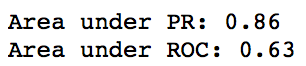

As you can see, the Random Forest model with fewer features performed even
better than the logistic regression model. Let's see how the logistic regression would
perform with a reduced number of features:

In [ ]:
LR_Model_2 = LogisticRegressionWithLBFGS \
.train(topFeatures_train, iterations=10)
LR_results_2 = (
topFeatures_test.map(lambda row: row.label) \
.zip(LR_Model_2 \
.predict(topFeatures_test \
.map(lambda row: row.features)))
).map(lambda row: (row[0], row[1] * 1.0))
LR_evaluation_2 = ev.BinaryClassificationMetrics(LR_results_2)
print('Area under PR: {0:.2f}' \
.format(LR_evaluation_2.areaUnderPR))
print('Area under ROC: {0:.2f}' \
.format(LR_evaluation_2.areaUnderROC))
LR_evaluation_2.unpersist()

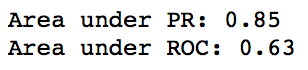

As you can see, both models can be simplified and still attain the same level of
accuracy. Having said that, you should always opt for a model with fewer variables.

## Summary  
In this chapter, we looked at the capabilities of the MLlib package of PySpark.
Even though the package is currently in a maintenance mode and is not actively
being worked on, it is still good to know how to use it. Also, for now it is the only
package available to train models while streaming data. We used MLlib to clean up,
transform, and get familiar with the dataset of infant deaths. Using that knowledge
we then successfully built two models that aimed at predicting the chance of infant
survival given the information about its mother, father, and place of birth.
In the next chapter, we will revisit the same problem, but using the newer package
that is currently the Spark recommended package for machine learning.